In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: TkAgg


In [40]:
data_file_path = "z6-20340(z6-20340)-Configuration 1-1689879751.4027638.csv"
cols_on_which_to_parse_dates = ['Timestamps']
df = pd.read_csv(data_file_path, skiprows = 2, parse_dates = cols_on_which_to_parse_dates)
print(df.columns)

df_downsampled_unagreggated = df.set_index("Timestamps")[" m/s Wind Speed"].resample("D")

Index(['Timestamps', '° Wind Direction', ' m/s Wind Speed', ' m/s Gust Speed',
       ' °C Anemometer Temp', '° X-axis Level', '° Y-axis Level',
       '% Battery Percent', ' mV Battery Voltage', ' kPa Reference Pressure',
       ' °C Logger Temperature'],
      dtype='object')


In [48]:
df_downsampled = pd.DataFrame()
df_downsampled["max"] = df_downsampled_unagreggated.max()
df_downsampled["min"] = df_downsampled_unagreggated.min()
df_downsampled["90_percentile"] = df_downsampled_unagreggated.quantile(0.9)
df_downsampled["10_percentile"] = df_downsampled_unagreggated.quantile(0.1)
df_downsampled["median"] = df_downsampled_unagreggated.quantile(0.5)
df_downsampled["sd"] = df_downsampled_unagreggated.std()
df_downsampled["mean"] = df_downsampled_unagreggated.mean()
print(df_downsampled.head(3))

             max   min  90_percentile  10_percentile  median        sd  \
Timestamps                                                               
2022-10-31  2.27  0.77          1.912          1.060   1.380  0.333225   
2022-11-01  2.41  0.13          1.890          0.620   1.235  0.485029   
2022-11-02  2.72  0.12          1.626          0.307   0.790  0.545876   

                mean  
Timestamps            
2022-10-31  1.434667  
2022-11-01  1.257674  
2022-11-02  0.907604  


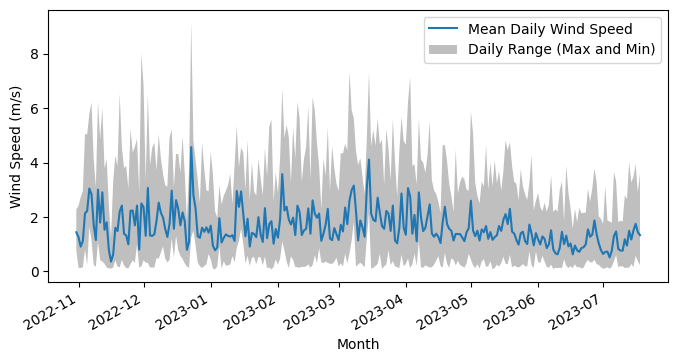

In [53]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, sharex = False, sharey = False, figsize = (8, 4))
ax1.plot(df_downsampled.index, df_downsampled["mean"], linestyle = "solid", label = "Mean Daily Wind Speed")
ax1.fill_between(df_downsampled.index, df_downsampled["max"], df_downsampled["min"], facecolor='gray', alpha=0.5, label = "Daily Range (Max and Min)")
fig.autofmt_xdate()
ax1.set_xlabel("Month")
ax1.set_ylabel("Wind Speed (m/s)")
ax1.legend()

In [59]:
df_rotor_speed = pd.DataFrame(
    columns = ["Load Case #", "Wind Speed (m/s)", "Rotor Speed (rpm)", "Rotor Speed (rad/s)", "Tip Speed Ratio (TSR)"], 
    data = [
        [1,  2,  23,  2.4,  3.0],
        [2,  4,  46,  4.8,  3.0],
        [3,  6,  69,  7.2,  3.0],
        [4,  8,  92,  9.6,  3.0],
        [5,  10, 115, 12.0, 3.0],
        [6,  12, 138, 14.5, 3.0],
        [7,  14, 160, 16.8, 3.0],
        [8,  16, 183, 19.2, 3.0],
        [9,  18, 206, 21.6, 3.0],
        [10, 20, 229, 24.0, 3.0],
        [11, 22, 252, 26.4, 3.0],
    ]
).set_index("Load Case #")
print(df_rotor_speed)

             Wind Speed (m/s)  Rotor Speed (rpm)  Rotor Speed (rad/s)  \
Load Case #                                                             
1                           2                 23                  2.4   
2                           4                 46                  4.8   
3                           6                 69                  7.2   
4                           8                 92                  9.6   
5                          10                115                 12.0   
6                          12                138                 14.5   
7                          14                160                 16.8   
8                          16                183                 19.2   
9                          18                206                 21.6   
10                         20                229                 24.0   
11                         22                252                 26.4   

             Tip Speed Ratio (TSR)  
Load Case #  

In [62]:
df_generator_power = pd.DataFrame(
    columns = ["Wind Speed Bin (m/s)", "Power Output (kW)"], 
    data = [
        [0.5,  0.00],
        [1.0,  0.00],
        [1.5,  0.00],
        [2.0,  0.00],
        [2.5,  0.00],
        [3.0,  0.00],
        [3.5,  0.00],
        [4.0,  0.19],
        [4.5,  0.33],
        [5.0,  0.51],
        [5.5,  0.71],
        [6.0,  1.00],
        [6.5,  1.38],
        [7.0,  1.74],
        [7.5,  2.27],
        [8.0,  2.58],
        [8.5,  3.23],
        [9.0,  4.04],
        [9.5,  4.67],
        [10.0, 5.41],
        [10.5, 6.59],
        [11.0, 7.58],
        [11.5, 9.18],
        [12.0, 9.40],
        [12.5, 10.20],
        [13.0, 10.82],
        [13.5, 13.01],
        [14.0, 13.01],
        [14.5, 13.01],
        [15.0, 13.01],
    ]
)
print(df_generator_power)

    Wind Speed Bin (m/s)  Power Output (kW)
0                    0.5               0.00
1                    1.0               0.00
2                    1.5               0.00
3                    2.0               0.00
4                    2.5               0.00
5                    3.0               0.00
6                    3.5               0.00
7                    4.0               0.19
8                    4.5               0.33
9                    5.0               0.51
10                   5.5               0.71
11                   6.0               1.00
12                   6.5               1.38
13                   7.0               1.74
14                   7.5               2.27
15                   8.0               2.58
16                   8.5               3.23
17                   9.0               4.04
18                   9.5               4.67
19                  10.0               5.41
20                  10.5               6.59
21                  11.0        